## Import libraries

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
from datetime import datetime
# !pip install uszipcode
# from uszipcode import SearchEngine
!pip install pandas numpy statsmodels
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Suppress all warnings
warnings.filterwarnings("ignore")

folder_path = '/content/drive/MyDrive/EY 2022-2023 Junior/Summer 2023/INCITE Buffett Letters project/coding instructions/media event/'

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
df = pd.read_csv(folder_path + 'letters_08032023.csv')
df

,doc_id,text,docvar1,docvar2,docvar3,docvar4,docvar5,docvar6,docvar7
0,h_01_15_2016_xxxxx_f,\t\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\t\t\t\t\t\t...,h,1,15,2016,XXXXX,f,R
1,h_01_01_2008_26624_f,\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\n\t\t\t\t\t\t...,h,1,1,2008,26624,f,R
2,h_01_01_2008_27526_f,"""Happy New Year!"" \t\t\t\t[REDACTED]\n...",h,1,1,2008,27526,f,R
3,h_01_01_2008_37025_f,"\t\t\t\t\t\t\t\t\t\t\t\tJanuary 1, 2008\n\t\t\...",h,1,1,2008,37025,f,R
4,h_01_01_2008_68510_f,"[redacted] [surname] \n[redacted]\nLincoln, Ne...",h,1,1,2008,68510,f,R
...,...,...,...,...,...,...,...,...,...
9015,t_xx_xx_xxxx_92392_f,"\nDear Mr. Buffett,\n\nMy name is [redacted] a...",t,xx,xx,xxxx,92392,f,R
9016,t_xx_xx_xxxx_92505_m,Dear Mr. Buffett\n\nI know your time is very v...,t,XX,XX,XXXX,92505,m,R
9017,t_xx_xx_xxxx_96790_f,"Dear Mr. Buffett and Family,\n\nMay I introduc...",t,xx,xx,xxxx,96790,f,R
9018,t_xx_xx_xxxx_99201_f,Dear Mr. Buffett:\n\nMy name is [redacted] and...,t,XX,XX,XXXX,99201,f,R


# Bar Chart

In [34]:
def count_phrases(text, phrases):
    count = 0
    for phrase in phrases:
        pattern = r'\b' + re.escape(phrase) + r'\w*'
        count += len(re.findall(pattern, text, re.IGNORECASE))
    return count

def check_phrases(text, phrases):
    for phrase in phrases:
        pattern = r'\b' + re.escape(phrase) + r'\w*'
        if len(re.findall(pattern, text, re.IGNORECASE)) > 0:
            return 1
    return 0

In [35]:
df[df['text'].isna()]
df = df[~df['text'].isna()]
df

,doc_id,text,docvar1,docvar2,docvar3,docvar4,docvar5,docvar6,docvar7,abuse_count,...,sn_count,sn_presence,housing_count,housing_presence,cancer_count,cancer_presence,ms_count,ms_presence,repairs_count,repairs_presence


In [36]:
df[['docvar2', 'docvar3', 'docvar4']] = df[['docvar2', 'docvar3', 'docvar4']].apply(pd.to_numeric, errors = 'coerce').astype('Int64')
df.rename(columns={'docvar2':'month','docvar3':'day','docvar4':'year'}, inplace=True)
df = df[(~df['month'].isna()) & (~df['year'].isna())]
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1), errors='coerce')
df['date'] = df['date'].dt.to_period('M')
df

,doc_id,text,docvar1,month,day,year,docvar5,docvar6,docvar7,abuse_count,...,sn_presence,housing_count,housing_presence,cancer_count,cancer_presence,ms_count,ms_presence,repairs_count,repairs_presence,date
0,h_01_15_2016_xxxxx_f,\t\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\t\t\t\t\t\t...,h,1,15,2016,XXXXX,f,R,0,...,0,1,1,1,1,0,0,0,0,2016-01
1,h_01_01_2008_26624_f,\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\n\t\t\t\t\t\t...,h,1,1,2008,26624,f,R,0,...,0,0,0,0,0,0,0,0,0,2008-01
2,h_01_01_2008_27526_f,"""Happy New Year!"" \t\t\t\t[REDACTED]\n...",h,1,1,2008,27526,f,R,1,...,0,1,1,2,1,0,0,0,0,2008-01
3,h_01_01_2008_37025_f,"\t\t\t\t\t\t\t\t\t\t\t\tJanuary 1, 2008\n\t\t\...",h,1,1,2008,37025,f,R,3,...,0,0,0,0,0,0,0,0,0,2008-01
4,h_01_01_2008_68510_f,"[redacted] [surname] \n[redacted]\nLincoln, Ne...",h,1,1,2008,68510,f,R,0,...,0,3,1,0,0,0,0,0,0,2008-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8773,t_12_xx_2012_53079_f,"Dear Mr Buffet,\t\t\t\tDecember 2012\n\n\nI kn...",t,12,<NA>,2012,53079,f,R,0,...,0,0,0,0,0,0,0,0,0,2012-12
8774,t_12_xx_2015_42728_f,[redacted]\n\nTo Whom It May Concern;\n\n2013 ...,t,12,<NA>,2015,42728,f,R,0,...,0,0,0,1,1,0,0,0,0,2015-12
8775,t_12_xx_2015_xxxxx_f,"Dear Ms. Buffet,\nI was writing to you because...",t,12,<NA>,2015,xxxxx,f,R,1,...,0,0,0,0,0,0,0,0,0,2015-12
8776,t_4_18_2012_97501_f,"[redacted]\n[redacted]\nMedford, OR 97501\n\n4...",t,4,18,2012,97501,f,R,0,...,0,0,0,0,0,0,0,0,0,2012-04


## Prevalence of "abuse" in letters with related Buffett press events

In [37]:
abuse = ['abus','domestic violence']

df.loc[:,'abuse_count'] = df.loc[:,'text'].apply(lambda x: count_phrases(x, phrases=abuse))
df.loc[:,'abuse_presence'] = df.loc[:,'text'].apply(lambda x: check_phrases(x, phrases=abuse))

df

,doc_id,text,docvar1,month,day,year,docvar5,docvar6,docvar7,abuse_count,...,sn_presence,housing_count,housing_presence,cancer_count,cancer_presence,ms_count,ms_presence,repairs_count,repairs_presence,date
0,h_01_15_2016_xxxxx_f,\t\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\t\t\t\t\t\t...,h,1,15,2016,XXXXX,f,R,0,...,0,1,1,1,1,0,0,0,0,2016-01
1,h_01_01_2008_26624_f,\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\n\t\t\t\t\t\t...,h,1,1,2008,26624,f,R,0,...,0,0,0,0,0,0,0,0,0,2008-01
2,h_01_01_2008_27526_f,"""Happy New Year!"" \t\t\t\t[REDACTED]\n...",h,1,1,2008,27526,f,R,1,...,0,1,1,2,1,0,0,0,0,2008-01
3,h_01_01_2008_37025_f,"\t\t\t\t\t\t\t\t\t\t\t\tJanuary 1, 2008\n\t\t\...",h,1,1,2008,37025,f,R,3,...,0,0,0,0,0,0,0,0,0,2008-01
4,h_01_01_2008_68510_f,"[redacted] [surname] \n[redacted]\nLincoln, Ne...",h,1,1,2008,68510,f,R,0,...,0,3,1,0,0,0,0,0,0,2008-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8773,t_12_xx_2012_53079_f,"Dear Mr Buffet,\t\t\t\tDecember 2012\n\n\nI kn...",t,12,<NA>,2012,53079,f,R,0,...,0,0,0,0,0,0,0,0,0,2012-12
8774,t_12_xx_2015_42728_f,[redacted]\n\nTo Whom It May Concern;\n\n2013 ...,t,12,<NA>,2015,42728,f,R,0,...,0,0,0,1,1,0,0,0,0,2015-12
8775,t_12_xx_2015_xxxxx_f,"Dear Ms. Buffet,\nI was writing to you because...",t,12,<NA>,2015,xxxxx,f,R,1,...,0,0,0,0,0,0,0,0,0,2015-12
8776,t_4_18_2012_97501_f,"[redacted]\n[redacted]\nMedford, OR 97501\n\n4...",t,4,18,2012,97501,f,R,0,...,0,0,0,0,0,0,0,0,0,2012-04


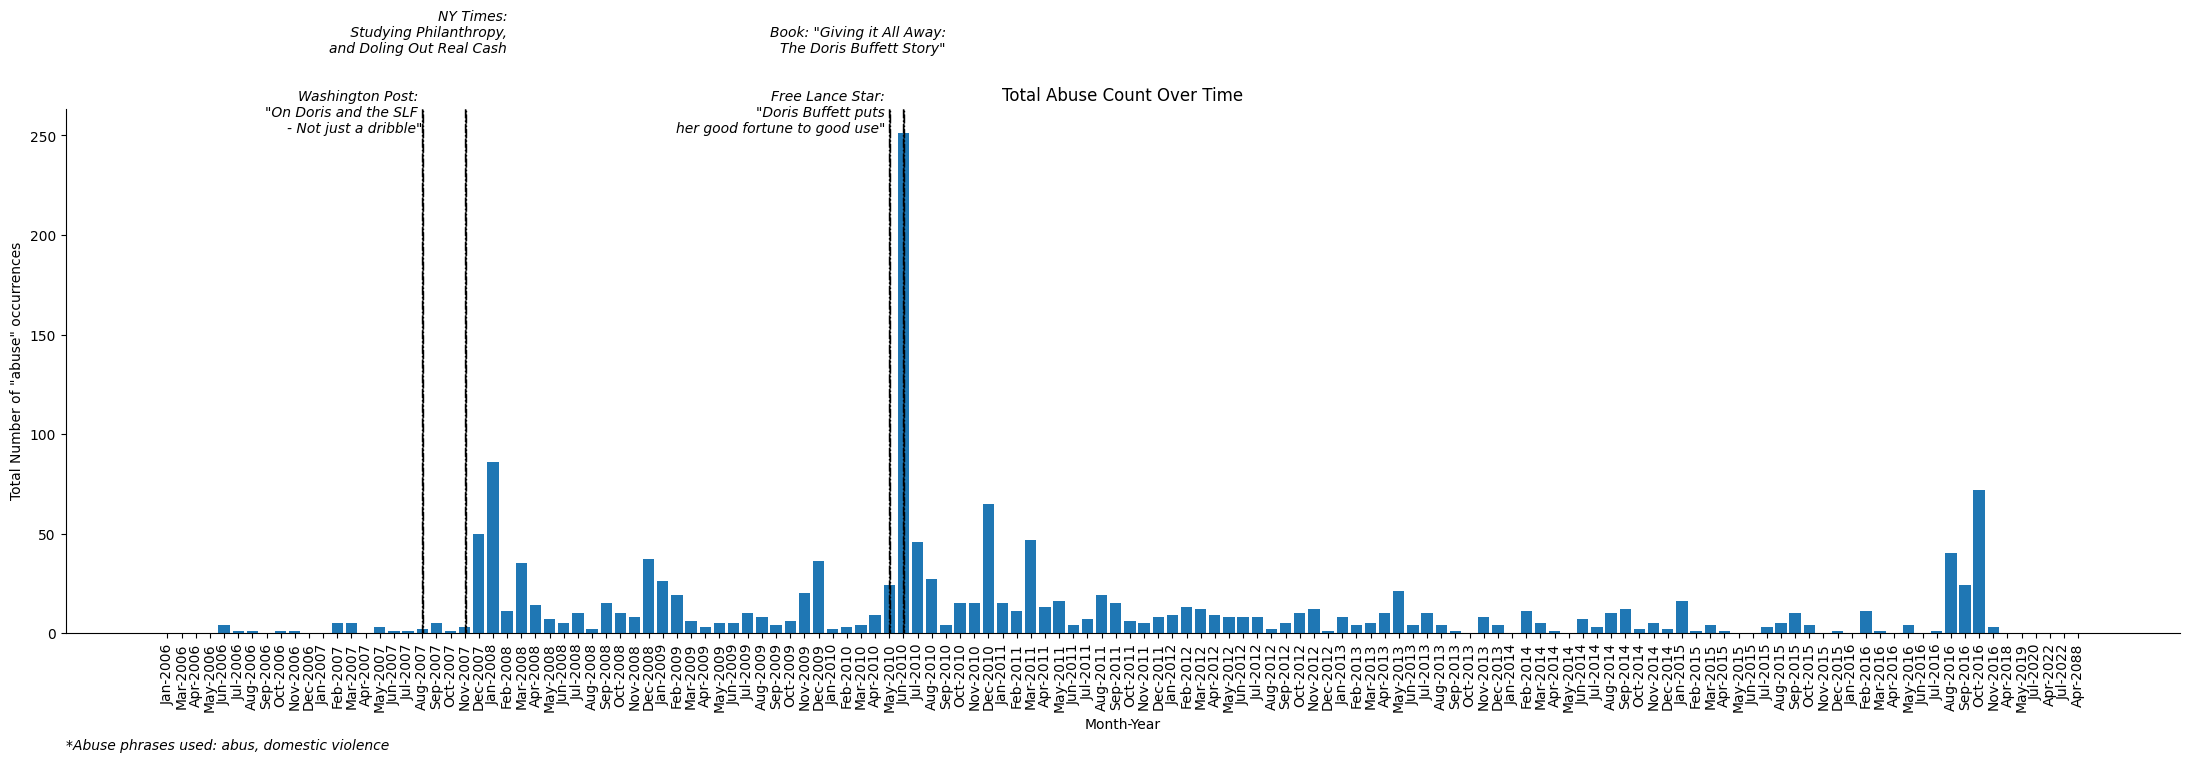

In [8]:
df_grouped = df.groupby('date', as_index=False)['abuse_count'].sum()

fig, ax = plt.subplots(figsize=(22, 8))
ax.bar(range(len(df_grouped)), df_grouped['abuse_count'], width=0.8)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Total Number of "abuse" occurrences')
ax.set_title('Total Abuse Count Over Time')

ax.set_xticks(range(len(df_grouped)))
ax.set_xticklabels(df_grouped['date'].dt.strftime('%b-%Y'), rotation=90)

# Annotate the graph with the Washington Post article
wsj_date = pd.to_datetime('2007-08-01').to_period('M')
wsj_loc = df_grouped[df_grouped['date'] == wsj_date].index[0]
ax.axvspan(wsj_loc, wsj_loc+0.05,color='black', linestyle='dashdot')
ax.text(wsj_loc, 250, 'Washington Post: \n"On Doris and the SLF \n- Not just a dribble"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# NY Times article
nyt_date = pd.to_datetime('2007-11-12').to_period('M')
nyt_loc = df_grouped[df_grouped['date'] == nyt_date].index[0]
ax.axvspan(nyt_loc, nyt_loc+0.1,color='black', linestyle='dashdot')
ax.text(nyt_loc+3, 290, 'NY Times:\n Studying Philanthropy,\nand Doling Out Real Cash', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Book
book_date = pd.to_datetime('2010-06-16').to_period('M')
book_loc = df_grouped[df_grouped['date'] == book_date].index[0]
ax.axvspan(book_loc, book_loc+0.05,color='black', linestyle='dashdot')
ax.text(book_loc+3, 290, 'Book: "Giving it All Away:\nThe Doris Buffett Story"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Free Lance Star
fls_date = pd.to_datetime('2010-05-01').to_period('M')
fls_loc = df_grouped[df_grouped['date'] == fls_date].index[0]
ax.axvspan(fls_loc, fls_loc+0.05,color='black', linestyle='dashdot')
ax.text(fls_loc, 250, 'Free Lance Star: \n"Doris Buffett puts \nher good fortune to good use" ', ha='right', va='bottom',fontstyle = 'italic', color='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, -0.2, f'*Abuse phrases used: {", ".join(abuse)}', ha='left', va='top', fontstyle = 'italic',transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [9]:
df_grouped = df.groupby('date', as_index=False)['doc_id'].count()
df_new = df.groupby('date', as_index=False)['abuse_presence'].sum()

df_grouped['abuse_presence'] = df_new['abuse_presence']
df_grouped['abuse_proportion'] = df_grouped['abuse_presence'] / df_grouped['doc_id']
df_grouped

,date,doc_id,abuse_presence,abuse_proportion
0,2006-01,2,0,0.000000
1,2006-03,1,0,0.000000
2,2006-04,2,0,0.000000
3,2006-05,1,0,0.000000
4,2006-06,76,3,0.039474
...,...,...,...,...
131,2019-05,1,0,0.000000
132,2020-07,1,0,0.000000
133,2022-04,1,0,0.000000
134,2022-07,1,0,0.000000


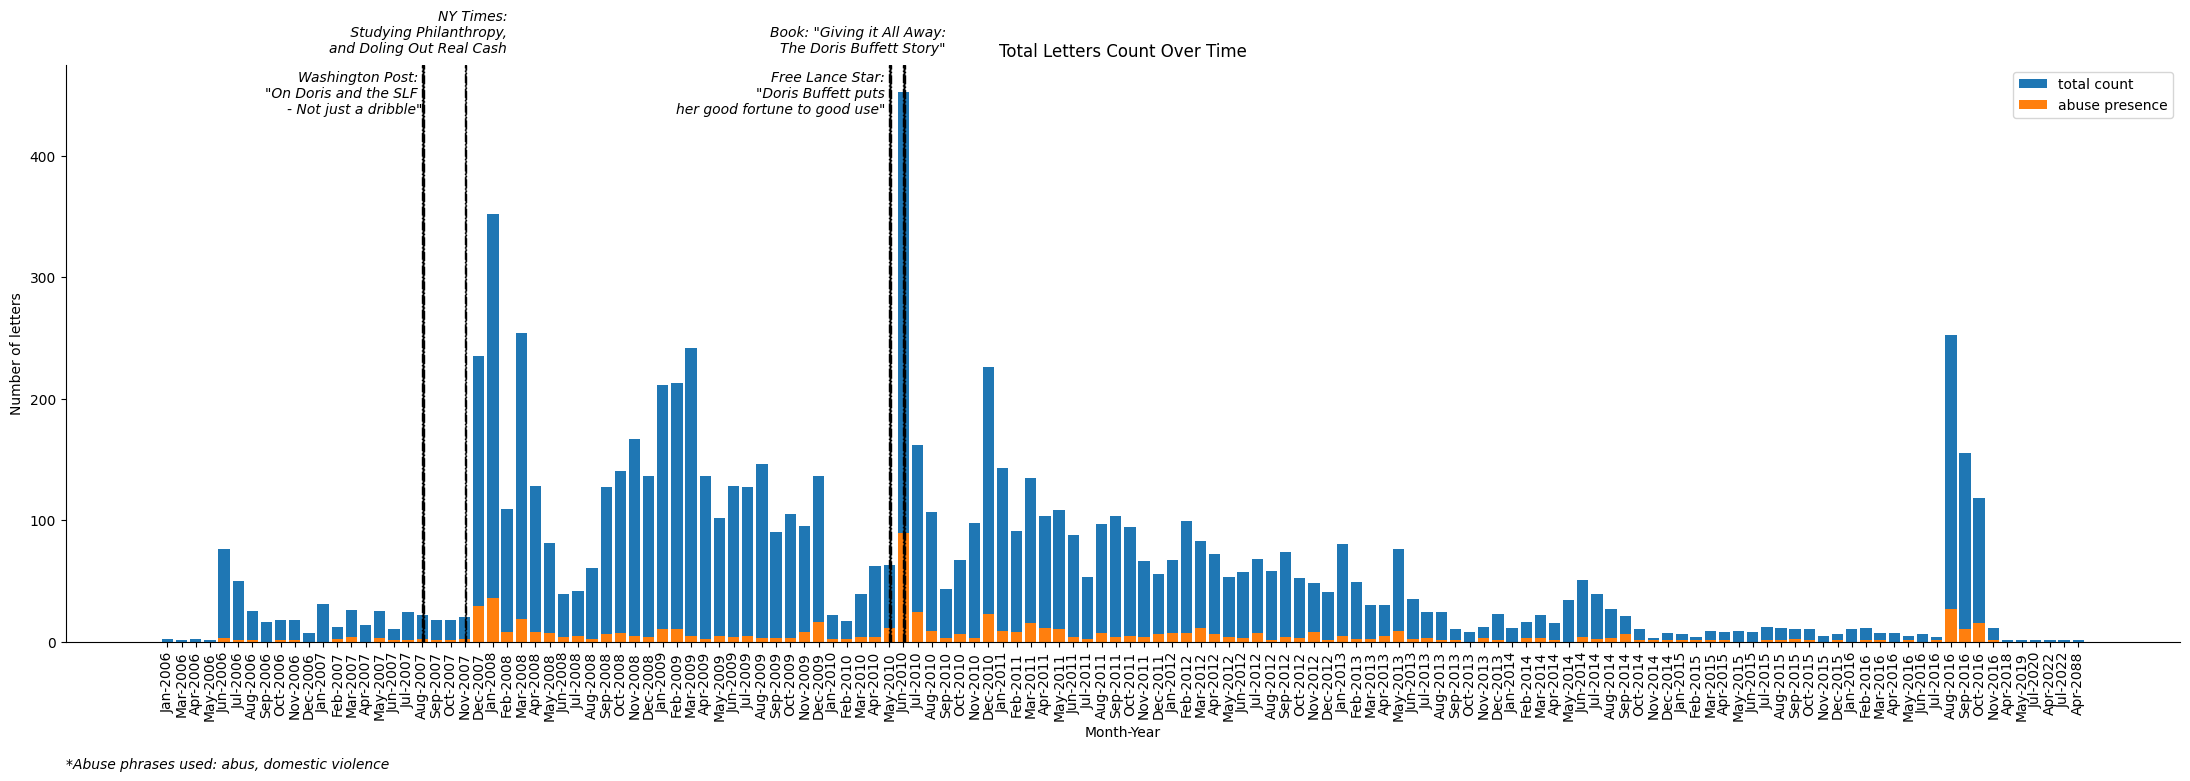

In [10]:
fig, ax = plt.subplots(figsize=(22, 8))
# ax.bar(range(len(df_grouped)), df_grouped['doc_id'], width=0.8)

# Bar width
width = 0.35

# Plot doc_id bars
ax.bar(range(len(df_grouped)), df_grouped['doc_id'], label='total count')

# Plot abuse_presence bars on top of doc_id bars
ax.bar(range(len(df_grouped)), df_grouped['abuse_presence'], label='abuse presence')

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of letters')
ax.set_title('Total Letters Count Over Time')

ax.legend()
ax.set_xticks(range(len(df_grouped)))
ax.set_xticklabels(df_grouped['date'].dt.strftime('%b-%Y'), rotation=90)

y_max = max(df_grouped['doc_id'])

# Annotate the graph with the Washington Post article
wsj_date = pd.to_datetime('2007-08-01').to_period('M')
wsj_loc = df_grouped[df_grouped['date'] == wsj_date].index[0]
ax.axvspan(wsj_loc, wsj_loc+0.1,color='black', linestyle='dashdot')
ax.text(wsj_loc, y_max-20, 'Washington Post: \n"On Doris and the SLF \n- Not just a dribble"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# NY Times article
nyt_date = pd.to_datetime('2007-11-12').to_period('M')
nyt_loc = df_grouped[df_grouped['date'] == nyt_date].index[0]
ax.axvspan(nyt_loc, nyt_loc+0.1,color='black', linestyle='dashdot')
ax.text(nyt_loc+3, y_max+30, 'NY Times:\n Studying Philanthropy,\nand Doling Out Real Cash', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Book
book_date = pd.to_datetime('2010-06-16').to_period('M')
book_loc = df_grouped[df_grouped['date'] == book_date].index[0]
ax.axvspan(book_loc, book_loc+0.1,color='black', linestyle='dashdot')
ax.text(book_loc+3, y_max+30, 'Book: "Giving it All Away:\nThe Doris Buffett Story"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Free Lance Star
fls_date = pd.to_datetime('2010-05-01').to_period('M')
fls_loc = df_grouped[df_grouped['date'] == fls_date].index[0]
ax.axvspan(fls_loc, fls_loc+0.1,color='black', linestyle='dashdot')
ax.text(fls_loc, y_max-20, 'Free Lance Star: \n"Doris Buffett puts \nher good fortune to good use" ', ha='right', va='bottom',fontstyle = 'italic', color='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, -0.2, f'*Abuse phrases used: {", ".join(abuse)}', ha='left', va='top', fontstyle = 'italic',transform=ax.transAxes)

plt.tight_layout()
plt.show()

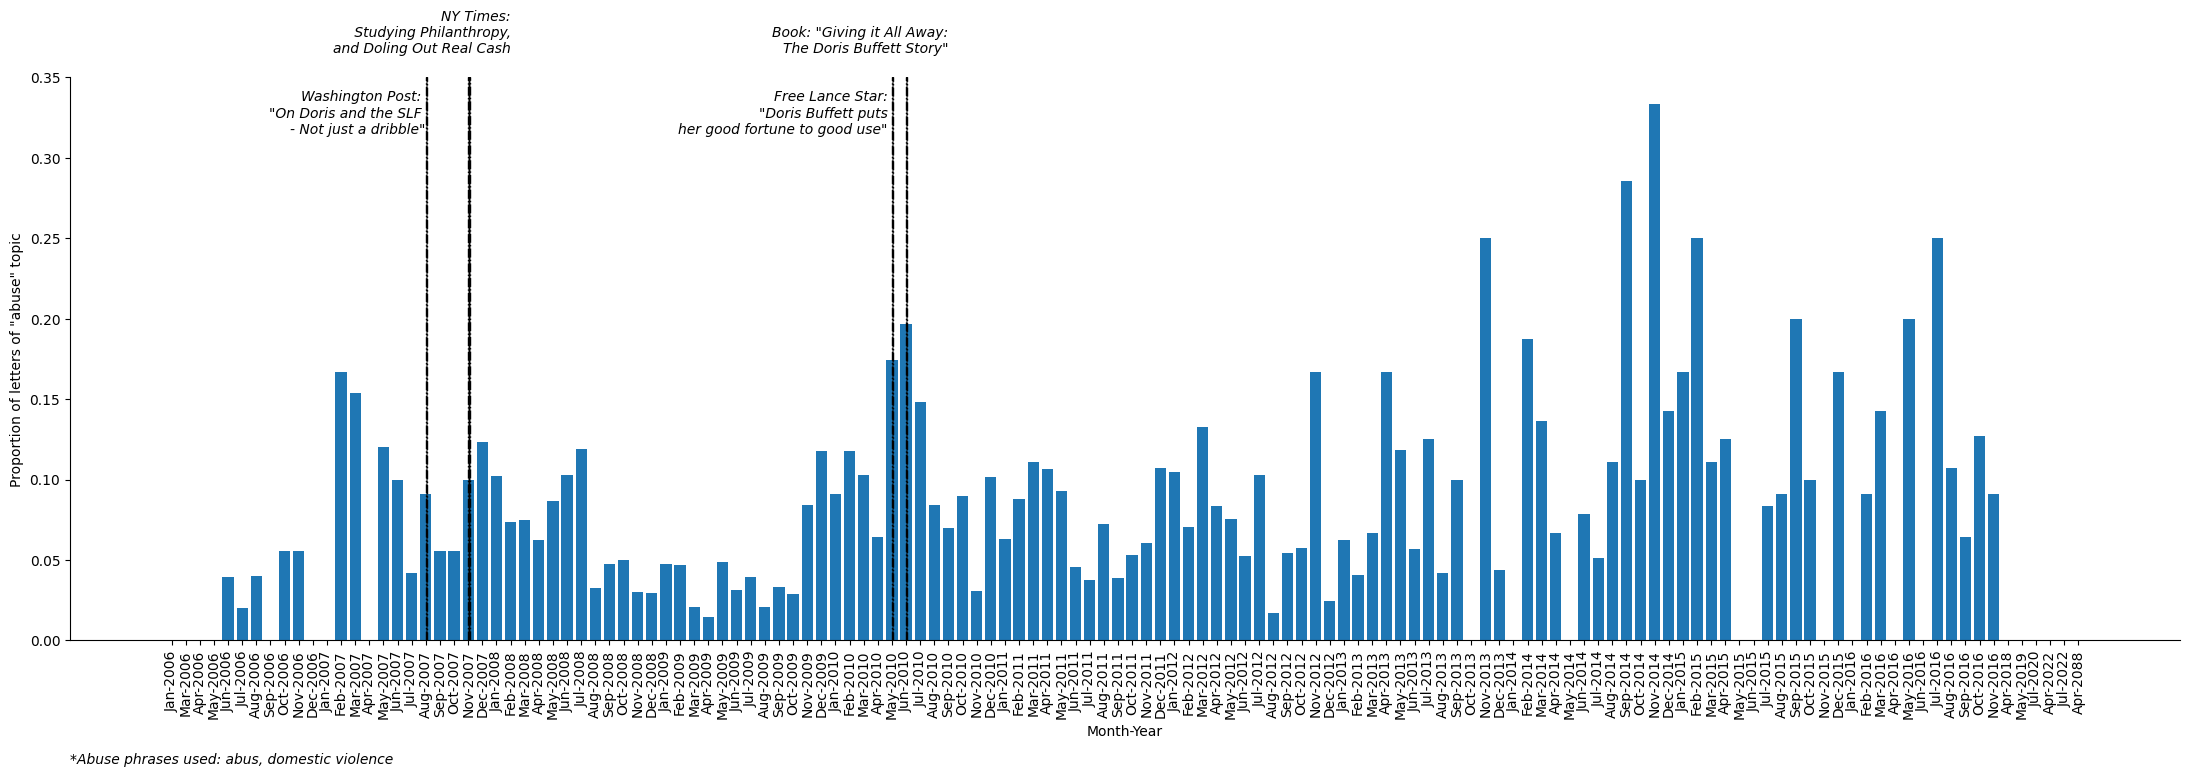

In [11]:
fig, ax = plt.subplots(figsize=(22, 8))
ax.bar(range(len(df_grouped)), df_grouped['abuse_proportion'], width=0.8)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Proportion of letters of "abuse" topic')

ax.set_xticks(range(len(df_grouped)))
ax.set_xticklabels(df_grouped['date'].dt.strftime('%b-%Y'), rotation=90)

y_max = max(df_grouped['abuse_proportion'])

# Annotate the graph with the Washington Post article
wsj_date = pd.to_datetime('2007-08-01').to_period('M')
wsj_loc = df_grouped[df_grouped['date'] == wsj_date].index[0]
ax.axvspan(wsj_loc, wsj_loc+0.1,color='black', linestyle='dashdot')
ax.text(wsj_loc, y_max-0.02, 'Washington Post: \n"On Doris and the SLF \n- Not just a dribble"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# NY Times article
nyt_date = pd.to_datetime('2007-11-12').to_period('M')
nyt_loc = df_grouped[df_grouped['date'] == nyt_date].index[0]
ax.axvspan(nyt_loc, nyt_loc+0.1,color='black', linestyle='dashdot')
ax.text(nyt_loc+3, y_max+0.03, 'NY Times:\n Studying Philanthropy,\nand Doling Out Real Cash', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Book
book_date = pd.to_datetime('2010-06-16').to_period('M')
book_loc = df_grouped[df_grouped['date'] == book_date].index[0]
ax.axvspan(book_loc, book_loc+0.1,color='black', linestyle='dashdot')
ax.text(book_loc+3, y_max+0.03, 'Book: "Giving it All Away:\nThe Doris Buffett Story"', ha='right', va='bottom',fontstyle = 'italic', color='black')

# Free Lance Star
fls_date = pd.to_datetime('2010-05-01').to_period('M')
fls_loc = df_grouped[df_grouped['date'] == fls_date].index[0]
ax.axvspan(fls_loc, fls_loc+0.1,color='black', linestyle='dashdot')
ax.text(fls_loc, y_max-0.02, 'Free Lance Star: \n"Doris Buffett puts \nher good fortune to good use" ', ha='right', va='bottom',fontstyle = 'italic', color='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, -0.2, f'*Abuse phrases used: {", ".join(abuse)}', ha='left', va='top', fontstyle = 'italic',transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Prevalence of "education" in letters

In [28]:
scholarship = ["scholarship","financial aid","tuition"]
df['scholarship_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=scholarship))
df['scholarship_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=scholarship))

vehicle = ['used car', 'used or new car', 'used truck','used van','vehicle','new car']
df['vehicle_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=vehicle))
df['vehicle_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=vehicle))

jail = ['prison','jail','incarcerate']
df['jail_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=jail))
df['jail_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=jail))

children = ['special need']
df['sn_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=children))
df['sn_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=children))

housing = ['mortgage','foreclos']
df['housing_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=housing))
df['housing_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=housing))

cancer = ['cancer']
df['cancer_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=cancer))
df['cancer_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=cancer))

df

,doc_id,text,docvar1,docvar2,docvar3,docvar4,docvar5,docvar6,docvar7,abuse_count,...,vehicle_count,vehicle_presence,jail_count,jail_presence,sn_count,sn_presence,housing_count,housing_presence,cancer_count,cancer_presence
0,h_01_15_2016_xxxxx_f,\t\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\t\t\t\t\t\t...,h,1,15,2016,XXXXX,f,R,0,...,0,0,0,0,0,0,1,1,1,1
1,h_01_01_2008_26624_f,\t\t\t\t\t\t\t\t\t\t\t[REDACTED]\n\t\t\t\t\t\t...,h,1,1,2008,26624,f,R,0,...,0,0,0,0,0,0,0,0,0,0
2,h_01_01_2008_27526_f,"""Happy New Year!"" \t\t\t\t[REDACTED]\n...",h,1,1,2008,27526,f,R,1,...,1,1,0,0,0,0,1,1,2,1
3,h_01_01_2008_37025_f,"\t\t\t\t\t\t\t\t\t\t\t\tJanuary 1, 2008\n\t\t\...",h,1,1,2008,37025,f,R,3,...,1,1,0,0,0,0,0,0,0,0
4,h_01_01_2008_68510_f,"[redacted] [surname] \n[redacted]\nLincoln, Ne...",h,1,1,2008,68510,f,R,0,...,0,0,0,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9015,t_xx_xx_xxxx_92392_f,"\nDear Mr. Buffett,\n\nMy name is [redacted] a...",t,xx,xx,xxxx,92392,f,R,0,...,0,0,3,1,0,0,0,0,0,0
9016,t_xx_xx_xxxx_92505_m,Dear Mr. Buffett\n\nI know your time is very v...,t,XX,XX,XXXX,92505,m,R,0,...,0,0,0,0,0,0,0,0,0,0
9017,t_xx_xx_xxxx_96790_f,"Dear Mr. Buffett and Family,\n\nMay I introduc...",t,xx,xx,xxxx,96790,f,R,0,...,0,0,0,0,0,0,0,0,0,0
9018,t_xx_xx_xxxx_99201_f,Dear Mr. Buffett:\n\nMy name is [redacted] and...,t,XX,XX,XXXX,99201,f,R,2,...,0,0,0,0,0,0,0,0,0,0


In [45]:
def annotate(date, max_column, title, ax):
  datetimef = pd.to_datetime(date).to_period('M')
  location = df_grouped[df_grouped['date'] == datetimef].index[0]
  ax.axvspan(location, location+0.05,color='black', linestyle='dashdot')
  ax.text(location, max_column, title, ha='right', va='bottom',fontstyle = 'italic', color='black')

def graph(column, topic, phrases, df_article, option):
    fig, ax = plt.subplots(figsize=(22, 8))

    if option == 'count':
        df_grouped = df.groupby('date', as_index=False)[column].sum()

        df_grouped['year'] = df_grouped['date'].dt.year

        distinct_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta', 'lime', 'grey']
        color_dict = dict(zip(df_grouped['year'].unique(), distinct_colors))

        ax.bar(range(len(df_grouped)), df_grouped[column], width=0.8, color=[color_dict[year] for year in df_grouped['year']])

        ax.set_xlabel('Month-Year')
        ax.set_ylabel(f'Total Number of {topic} occurrences')
        ax.set_title(f'Total {topic} Count Over Time')

        y_max = max(df_grouped[column])

        ax.set_xticks(range(len(df_grouped)))
        ax.set_xticklabels(df_grouped['date'].dt.strftime('%b-%Y'), rotation=90)

    elif option == 'proportion':
        df_proportion = df.groupby('date', as_index=False)['doc_id'].count()
        df_proportion2 = df.groupby('date', as_index=False)[column].sum()
        df_proportion[column] = df_proportion2[column]
        df_proportion['proportion'] = df_proportion[column] / df_proportion['doc_id']

        # Plot doc_id bars
        ax.bar(range(len(df_proportion)), df_proportion['doc_id'], label='total count')

        # Plot abuse_presence bars on top of doc_id bars
        ax.bar(range(len(df_proportion)), df_proportion[column], label=column)

        ax.set_xlabel('Month-Year')
        ax.set_ylabel('Number of letters')
        ax.set_title('Total Letters Count Over Time')

        ax.legend()
        ax.set_xticks(range(len(df_proportion)))
        ax.set_xticklabels(df_proportion['date'].dt.strftime('%b-%Y'), rotation=90)

        y_max = max(df_proportion['doc_id'])

    elif option == 'aproportion':
        df_proportion = df.groupby('date', as_index=False)['doc_id'].count()
        df_proportion2 = df.groupby('date', as_index=False)[column].sum()
        df_proportion[column] = df_proportion2[column]
        df_proportion['proportion'] = df_proportion[column] / df_proportion['doc_id']

        df_proportion['year'] = df_proportion['date'].dt.year

        distinct_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta', 'lime', 'grey']
        color_dict = dict(zip(df_proportion['year'].unique(), distinct_colors))

        ax.bar(range(len(df_proportion)), df_proportion['proportion'], width=0.8, color=[color_dict[year] for year in df_proportion['year']])

        ax.set_xlabel('Month-Year')
        ax.set_ylabel(f'Proportion of letters of {topic} topic')

        ax.set_xticks(range(len(df_proportion)))
        ax.set_xticklabels(df_proportion['date'].dt.strftime('%b-%Y'), rotation=90)

        y_max = max(df_proportion['proportion'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    counter = 0
    for index, row in df_article.iterrows():
        if counter % 2 != 0:
            new = y_max + y_max / 10
        else:
            new = y_max
        counter += 1
        annotate(row['date'], new, row['title'], ax)

    ax.text(0, -0.2, f'*{topic} phrases used: {", ".join(phrases)}', ha='left', va='top', fontstyle = 'italic',transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

In [41]:
dfa = pd.read_csv(folder_path + 'relevant article.csv')
dfa['date'] = dfa['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y").strftime("%Y-%m-%d"))
dfa['ashley notes 08-07-2023'] = dfa['ashley notes 08-07-2023'].fillna('')
dfa['date'][0]

'2006-06-25'

In [42]:
dfa = dfa.drop([9,10])
dfa['title'][11] = 'Book: Giving it All Away \n The Doris Buffett Story'
dfa['title'][4] = 'Washington Post: On Doris and the \n Sunshine Ladies  Foundation - Not just\n  A Dribble'
dfa['ashley notes 08-07-2023'][11] = 'scholarship, abuse, bipolar, housing, prisoner, vehicle, sclerosis, repairs'
dfa

,date,Media Type,Publication Name,Title of the article,title,event,Link to the article,Notes,amy notes 08-03-2023,ashley notes 08-07-2023
0,2006-06-25,Online Publication,NYT,Buffett to Give Billions\n to Gates Charity a...,NYT: Buffett to Give Billions\n to Gates Char...,Buffett announces he is giving away his fortune,Article,Online Publication,look at this article to see what issues Buffet...,generic
1,2006-06-26,Television,ABC News: \n Good Morning America,GOOD MORNING AMERICA,ABC News: \n Good Morning America: GOOD MORNIN...,"You can't take it with you. Warren Buffett, Am...",NaN,NaN,NaN,generic
2,2006-12-06,Online publication,New York Times,Buffett to Give Bulk of \n His \n Fortune to G...,New York Times: Buffett to Give Bulk of \n His...,"Warren E. Buffett, the chairman of Berkshire H...",NYT article,NaN,NaN,generic
3,2007-04-03,NaN,NaN,NaN,"New Century Financial, which specializes in su...","New Century Financial, which specializes in su...",NaN,NaN,NaN,housing
4,2007-08-03,Online publication,Washington Post,On Doris and the \n Sunshine Ladies\n Foundat...,Washington Post: On Doris and the \n Sunshine ...,"With so many worthy causes, big and small, how...",Link,NaN,"abuse, scholarships","abuse, scholarship"
5,2007-08-03,Oline publication,World Street Journal,The Other Buffett\n Warren Buffett doesn't\n g...,World Street Journal: The Other Buffett\n Warr...,"One day last July, UPS delivered a large cardb...",Article,"MS/multiple schlerosis, custody, used car, hea...",NaN,"vehicle, sclerosis"
6,2007-12-10,NaN,CBS Early Show,NaN,CBS Early Show:,W and D Buffett appear on the Early Show on CB...,12/10/07,NaN,NaN,can't find transcript
7,2007-12-11,Online publication,New York Times,"Studying Philanthropy, \n and Doling Out Real ...","New York Times: Studying Philanthropy, \n and ...","Later, the group worried aloud about making th...",Article,NaN,"home repairs, education, abuse,","home repairs, scholarship, abuse"
8,2010-05-01,Online publication,Free Lance-Star,Doris Buffett puts her \n good fortune to good...,Free Lance-Star : Doris Buffett puts her \n go...,"Shortly after her mother died in 1996, Buffett...",Link to the article,Ciculation in Virginia,"children with special needs, congenital illnes...","children with special needs, scholarship, abus..."
11,2010-06-16,Book,NaN,Giving it All Away: \n The Doris Buffett Story,Book: Giving it All Away \n The Doris Buffett ...,Warren Buffett's big sister Doris has never lo...,Link to Amazon,NaN,"bipolar, foreclosure, losing my home","scholarship, abuse, bipolar, housing, prisoner..."


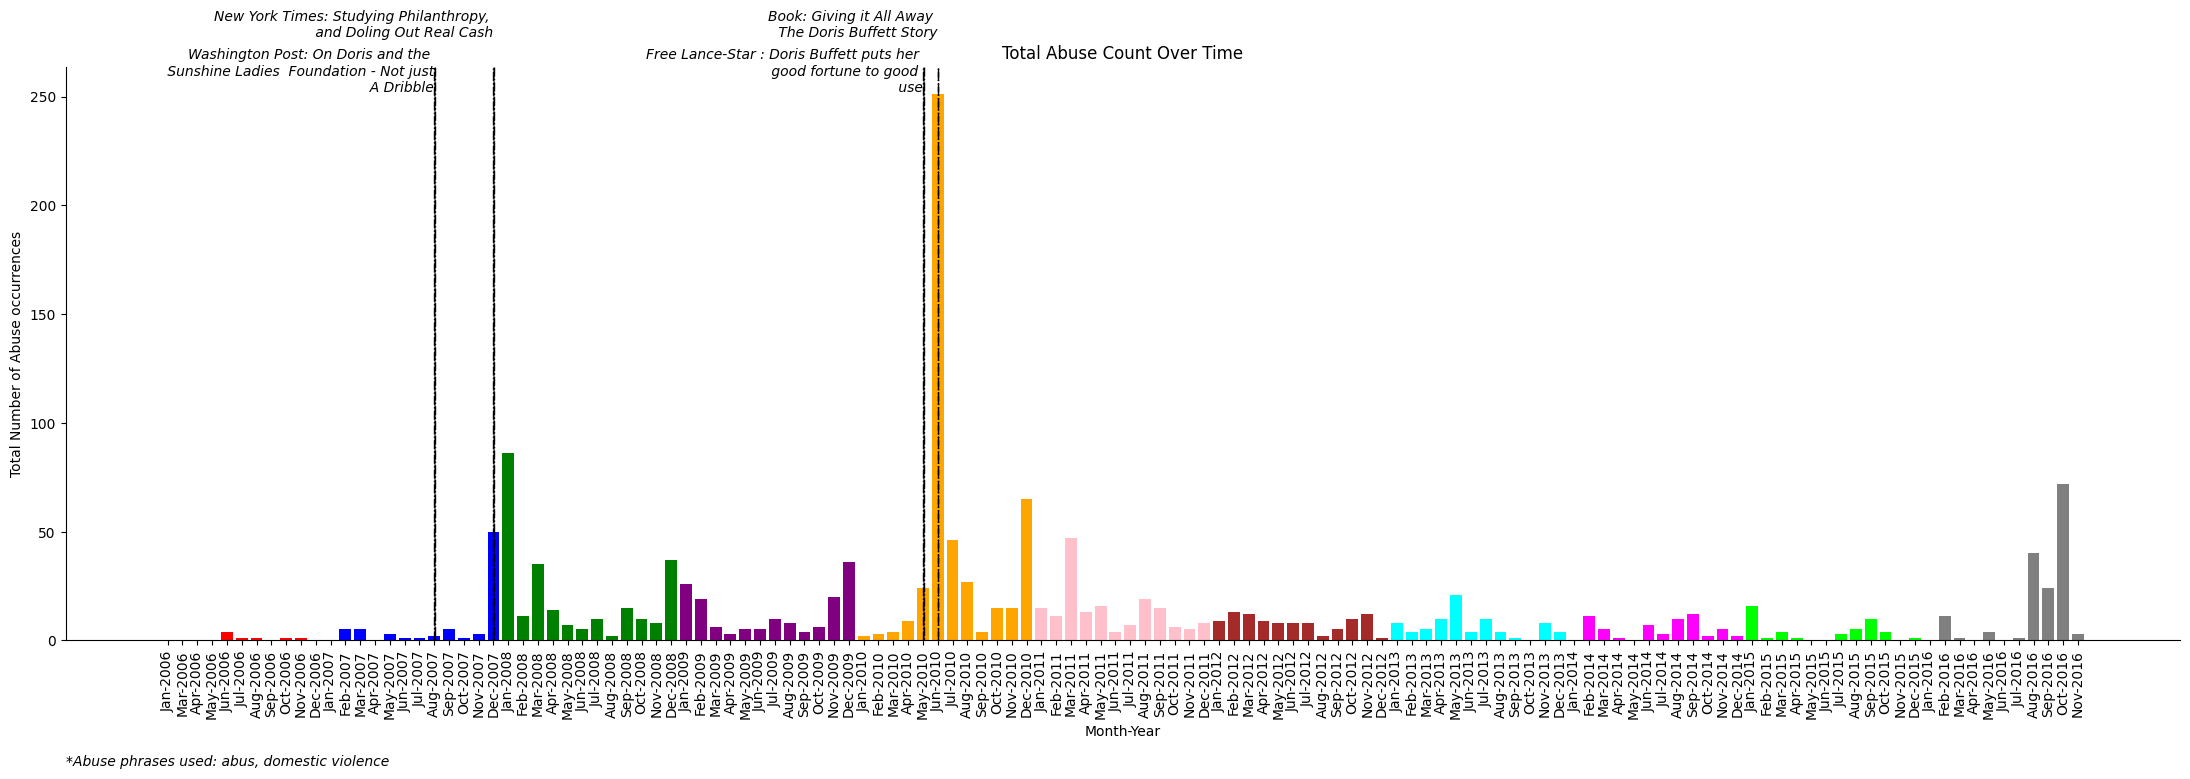

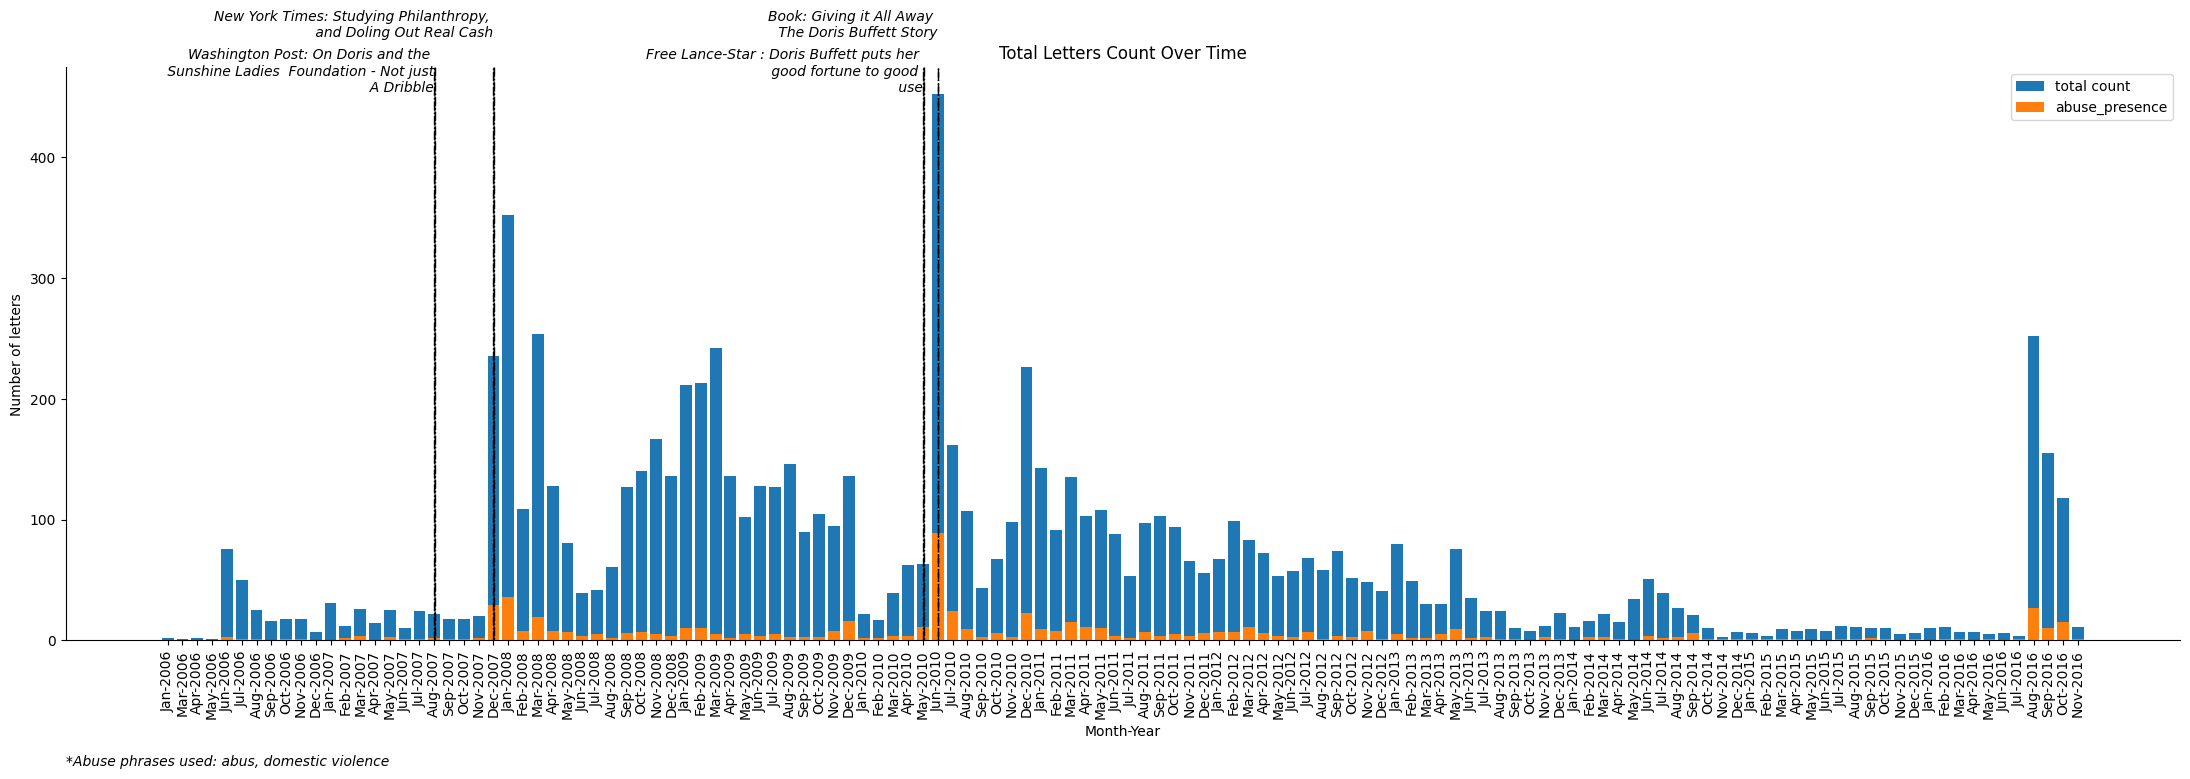

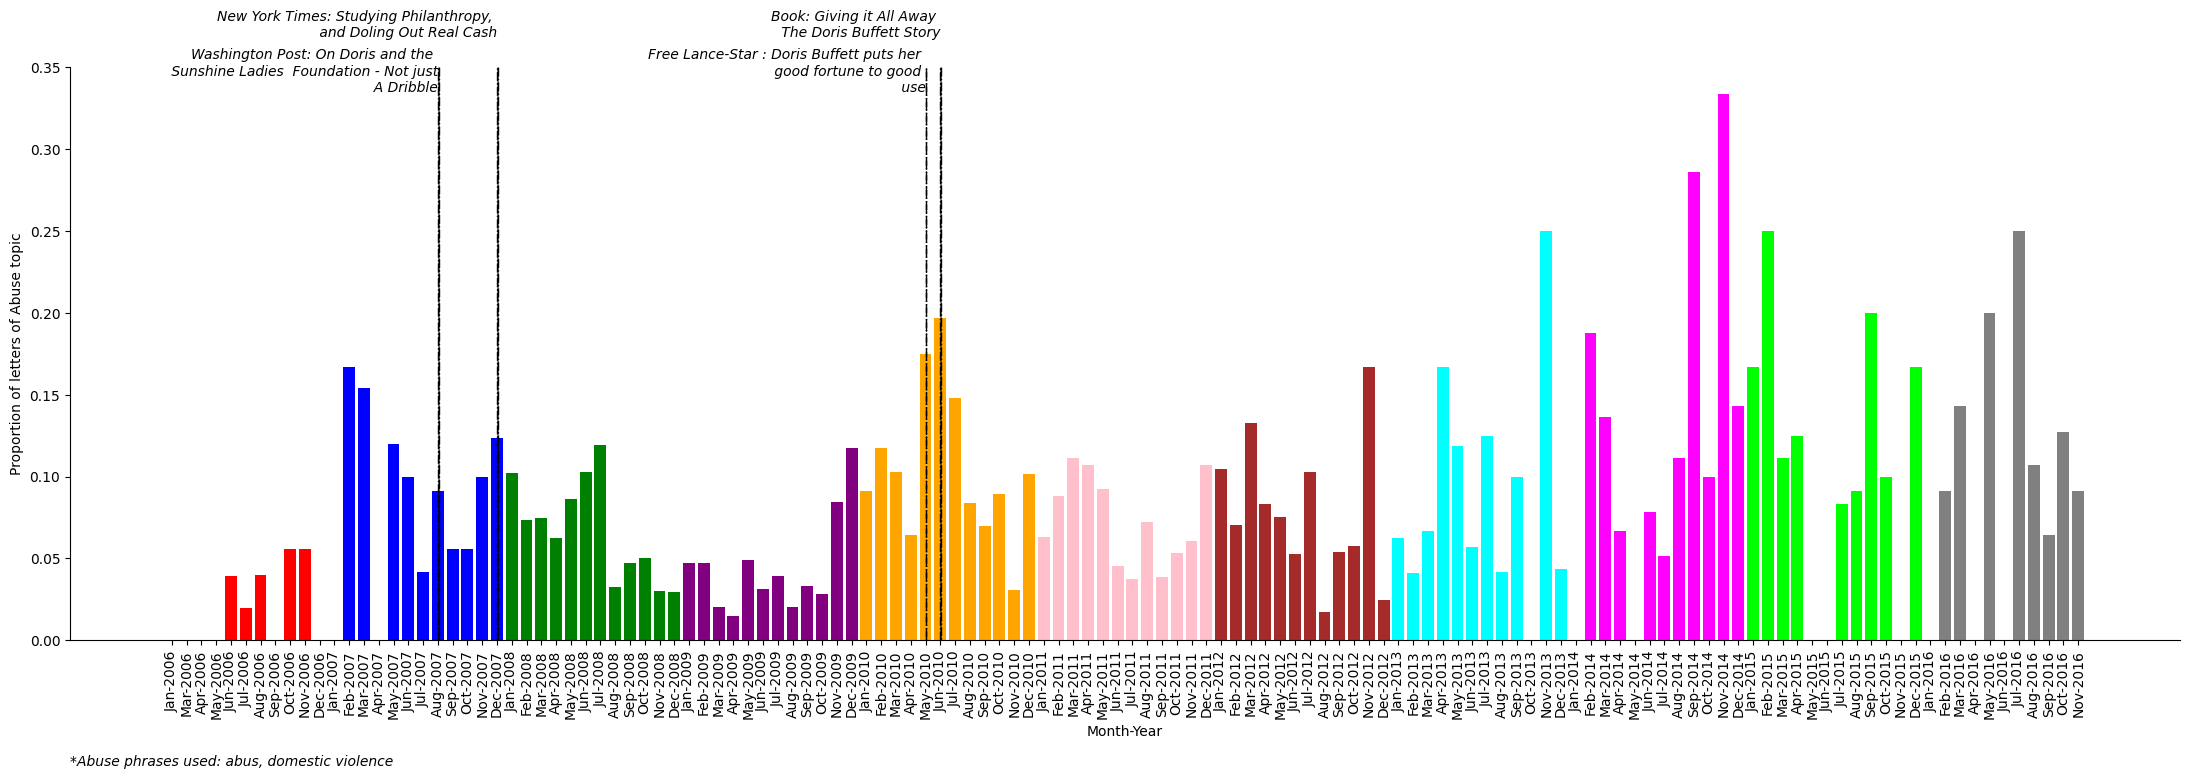

In [46]:
graph('abuse_count','Abuse', abuse,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('abuse')], option='count')
graph('abuse_presence','Abuse', abuse,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('abuse')], option='proportion')
graph('abuse_presence','Abuse', abuse,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('abuse')], option ='aproportion')

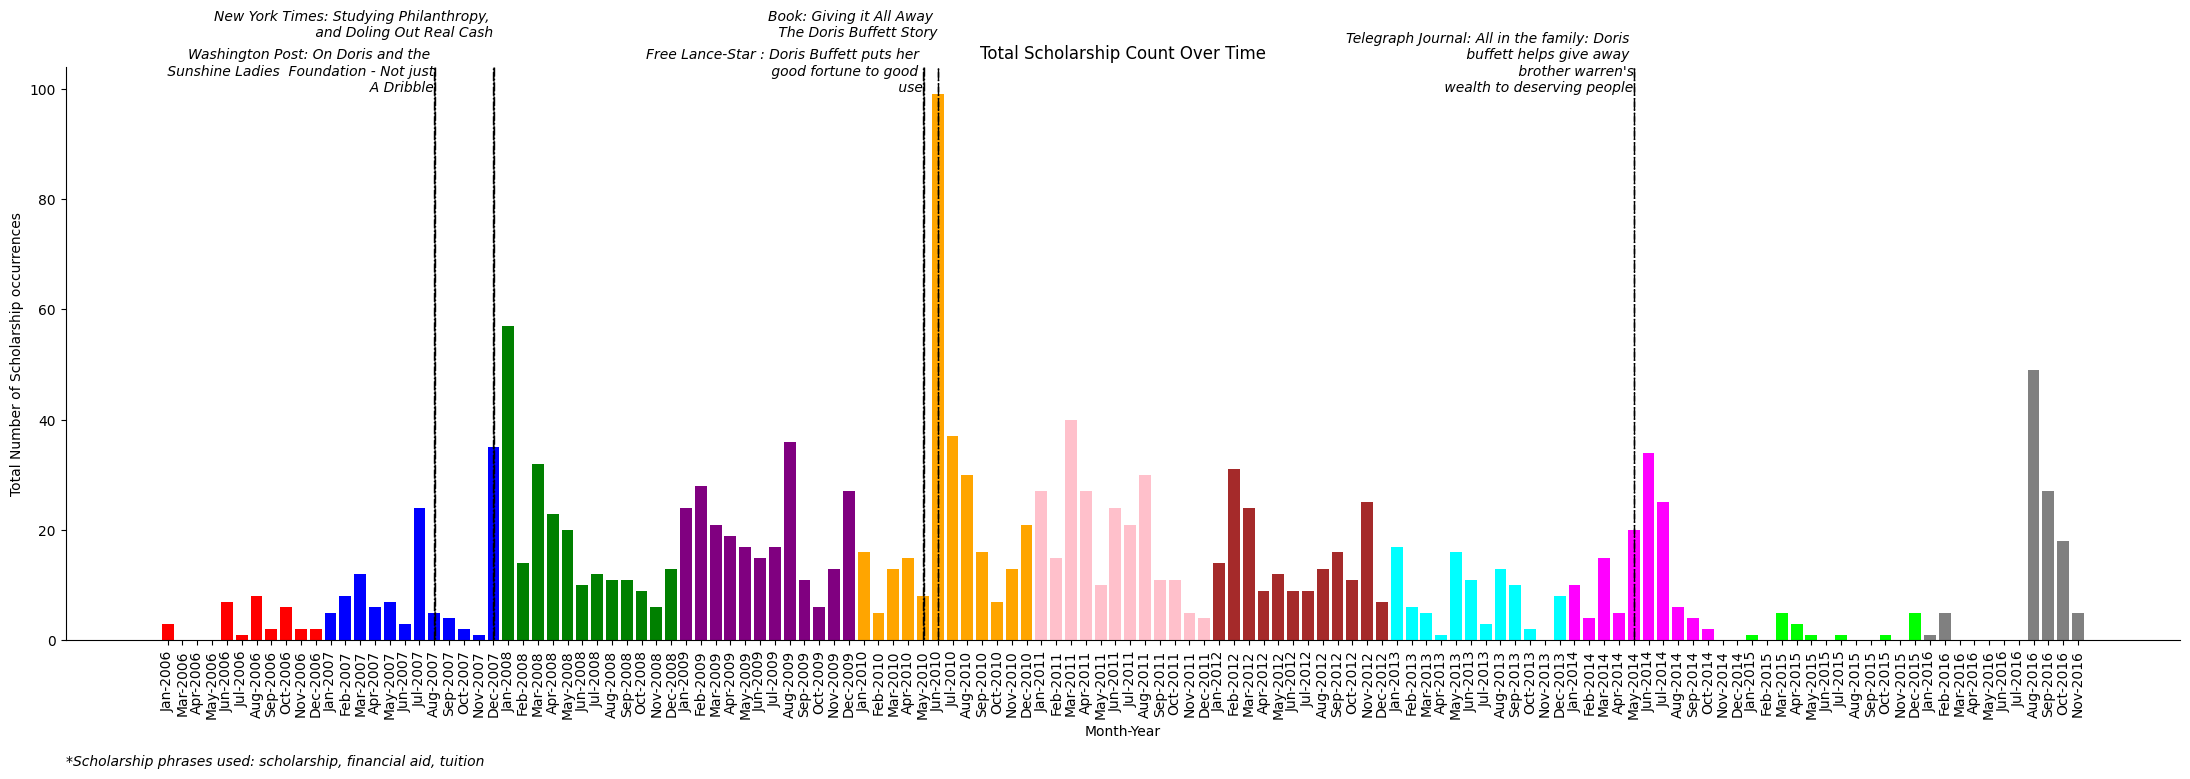

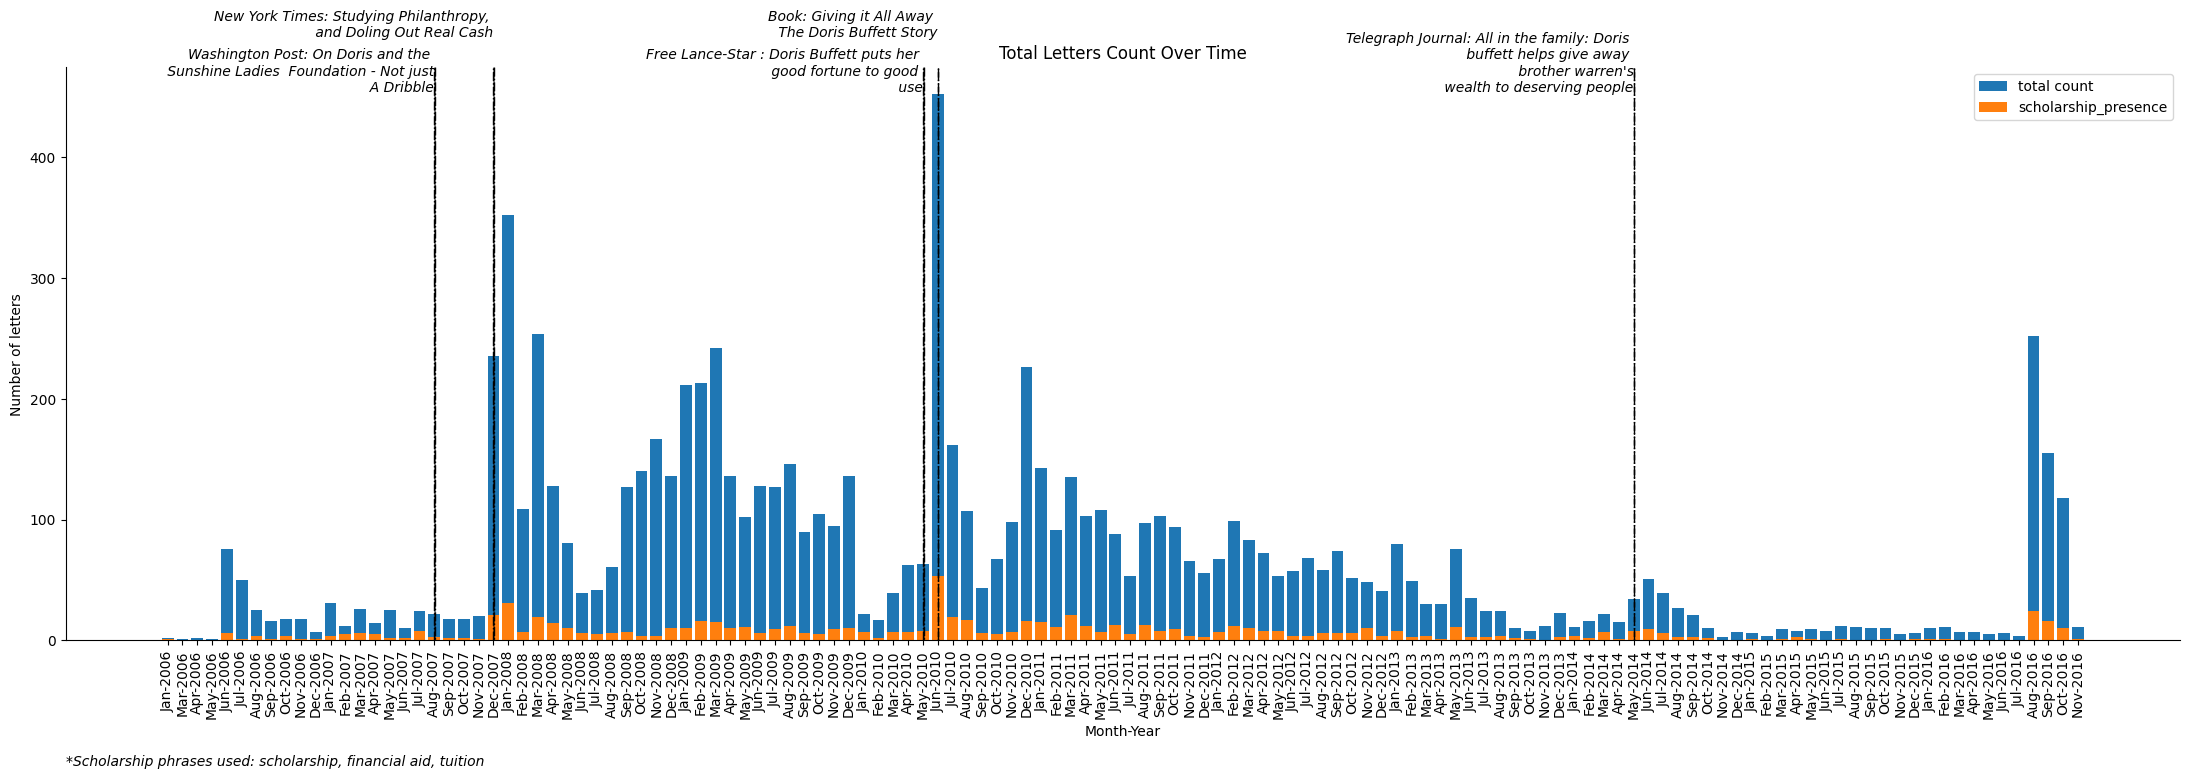

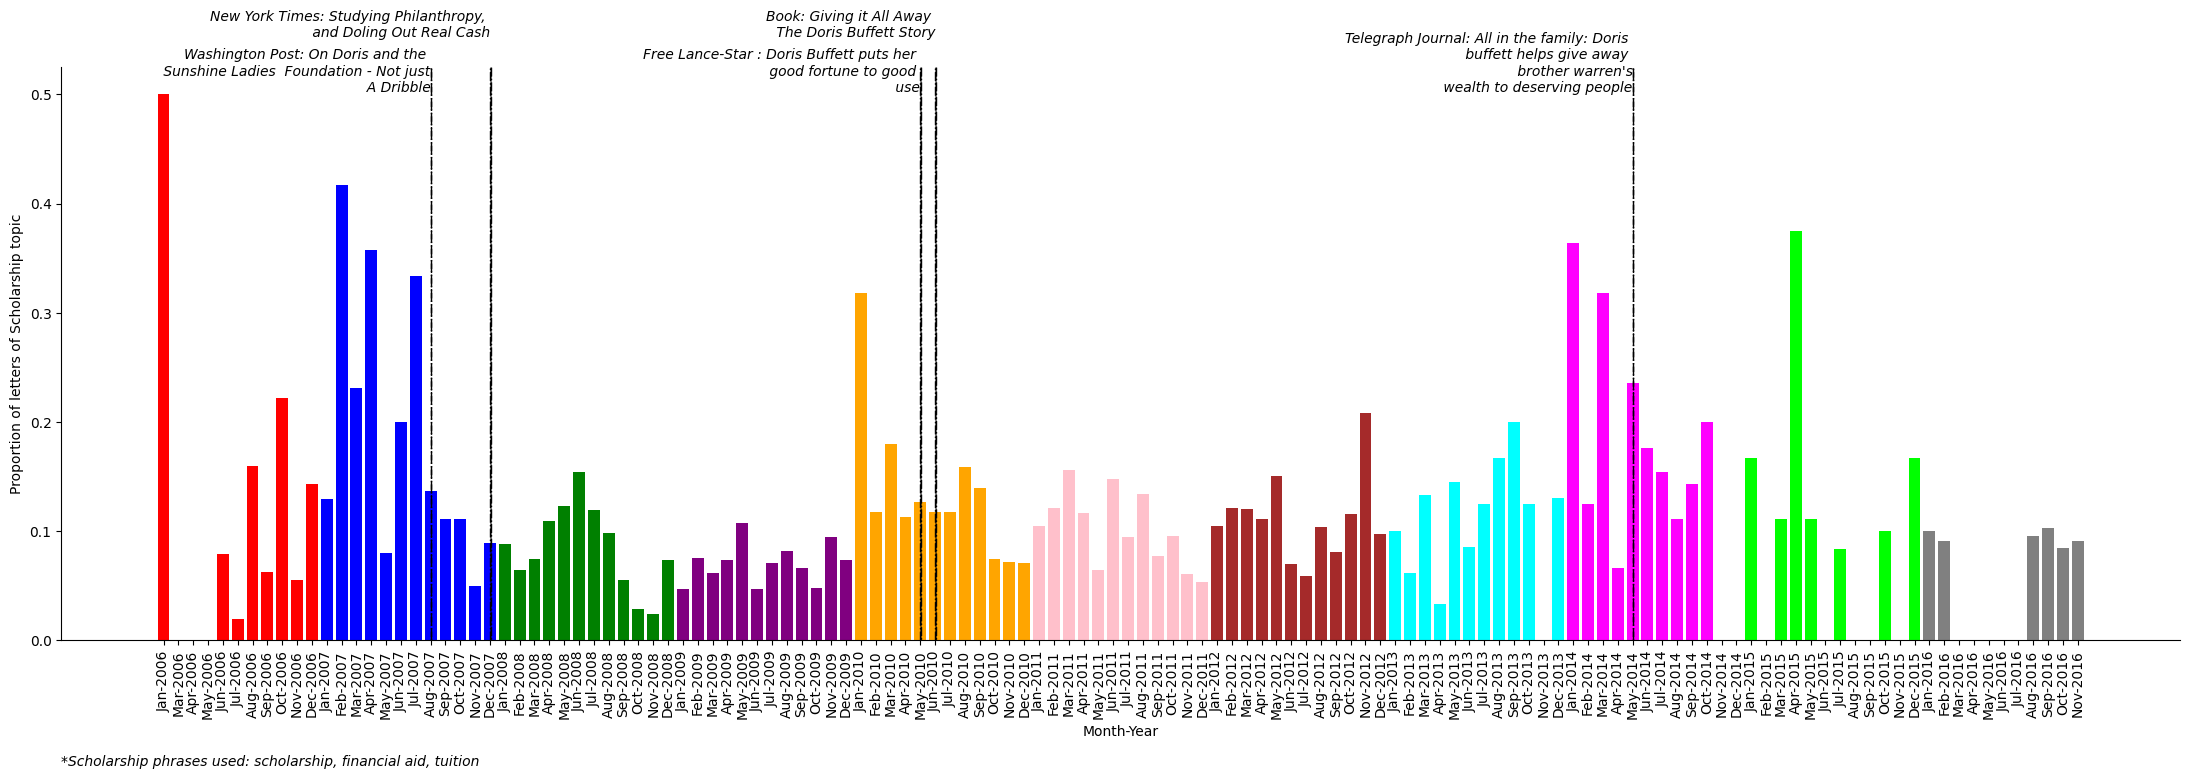

In [47]:
graph('scholarship_count','Scholarship', scholarship,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('scholarship')], option='count')
graph('scholarship_presence','Scholarship', scholarship,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('scholarship')], option='proportion')
graph('scholarship_presence','Scholarship', scholarship,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('scholarship')], option ='aproportion')

In [ ]:
graph('vehicle_count','Vehicle', vehicle,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('vehicle')], option='count')
graph('vehicle_presence','Vehicle', vehicle,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('vehicle')], option='proportion')
graph('vehicle_presence','Vehicle', vehicle,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('vehicle')], option ='aproportion')

In [ ]:
graph('jail_count','Incarcerated', jail,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('prisoner')], option='count')
graph('jail_presence','Incarcerated', jail,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('prisoner')], option='proportion')
graph('jail_presence','Incarcerated', jail,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('prisoner')], option='aproportion')

In [ ]:
graph('housing_count','Housing', housing,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('housing')], option='count')
graph('housing_presence','Housing', housing,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('housing')], option='proportion')
graph('housing_presence','Housing', housing,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('housing')], option='aproportion')

In [ ]:
graph('cancer_count','Cancer', cancer,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('cancer')], option='count')
graph('cancer_presence','Cancer', cancer,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('cancer')], option='proportion')
graph('cancer_presence','Cancer', cancer,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('cancer')], option='aproportion')

## Home repairs

In [ ]:
def count_phrases(text, phrases):
    count = 0
    for phrase in phrases:
        pattern = r'\b' + re.escape(phrase) + r'\w*'
        count += len(re.findall(pattern, text))
    return count

def check_phrases(text, phrases):
    for phrase in phrases:
        pattern = r'\b' + re.escape(phrase) + r'\w*'
        if len(re.findall(pattern, text)) > 0:
            return 1
    return 0

In [29]:
# ms = ["sclerosis","M.S", "Sclerosis","MS"]
ms = ["sclerosis","M.S", "Sclerosis"]

df['ms_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=ms))
df['ms_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=ms))

In [ ]:
graph('ms_count','Sclerosis', ms,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('sclerosis')], option='count')
graph('ms_presence','Sclerosis', ms,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('sclerosis')], option='proportion')
graph('ms_presence','Sclerosis', ms,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('sclerosis')], option ='aproportion')

In [30]:
home_repairs = ['home repair']

df['repairs_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=home_repairs))
df['repairs_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=home_repairs))

In [ ]:
graph('repairs_count','Home Repair', home_repairs,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('repairs')], option='count')
graph('repairs_presence','Home Repair', home_repairs,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('repairs')], option='proportion')
graph('repairs_presence','Home Repair', home_repairs,\
      dfa[dfa['ashley notes 08-07-2023'].str.contains('repairs')], option ='aproportion')

# Heatmap

In [ ]:
df_hm = df.groupby(['docvar5']).agg({'doc_id': 'count'}).reset_index()
df_hm['docvar5'] = df_hm['docvar5'].str.zfill(5)
df_hm

,docvar5,doc_id
0,021XX,1
1,02xxx,1
2,076XX,1
3,10001,1
4,01001,1
...,...,...
6068,XOCOAO,1
6069,XXXXX,26
6070,0intl,1
6071,intlx,1


In [ ]:
df_hm = df_hm[df_hm['docvar5'].str.isnumeric() & (df_hm['docvar5'].str.len() == 5)]

In [ ]:
search = SearchEngine()

def map_zip_to_state(zip_code):
    result = search.by_zipcode(zip_code)
    if result:
        return result.state
    else:
        return None

# Apply the function to create a new 'State' column
df_hm['State'] = df_hm['docvar5'].apply(map_zip_to_state)

In [ ]:
grouped = df_hm.groupby('State')['doc_id'].sum().reset_index()
grouped

In [ ]:
# Load ZCTA geometries from a shapefile
zcta_shapefile_path = folder_path + 'shapefile/tl_2010_us_zcta510/tl_2010_us_zcta510.shp'
zcta_gdf = gpd.read_file(zcta_shapefile_path)

In [ ]:
merged_gdf = zcta_gdf.merge(df_hm, left_on='ZCTA5CE10', right_on='docvar5', how='left')

In [ ]:
merged_gdf['doc_id'] = merged_gdf['doc_id'].fillna(0).astype(int)

In [ ]:
merged_gdf['abuse_presence'] = merged_gdf['abuse_presence'].fillna(0).astype(int)
merged_gdf['abuse_presence'] = merged_gdf['abuse_presence'].replace([2,3,4], 1)
merged_gdf

In [ ]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
merged_gdf.plot(column='doc_id', cmap='Reds', linewidth=0.1, ax=ax, edgecolor='0.8', legend=True)

# Set title
ax.set_title('Letters by Location')

# Show the plot
plt.show()

In [ ]:
shapefile_path = folder_path + 'shapefile/States_shapefile/States_shapefile.shp'
gdf = gpd.read_file(shapefile_path)
gdf

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
1,2,NaN,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,5,NaN,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."
5,6,ECOMAP,CO,COLORADO,F,924,"POLYGON ((-102.04446 37.64147, -102.04201 37.3..."
6,7,SIMS,CT,CONNECTICUT,F,925,"POLYGON ((-73.53039 41.52275, -73.51715 41.665..."
7,8,NaN,DE,DELAWARE,P,926,"POLYGON ((-75.70707 38.55759, -75.71071 38.649..."
8,9,NaN,DC,DISTRICT OF COLUMBIA,P,927,"POLYGON ((-77.00793 38.96667, -76.91090 38.890..."
9,10,NaN,FL,FLORIDA,P,928,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ..."


In [ ]:
merged_gdf = gdf.merge(grouped, left_on='State_Code', right_on='State', how='left')

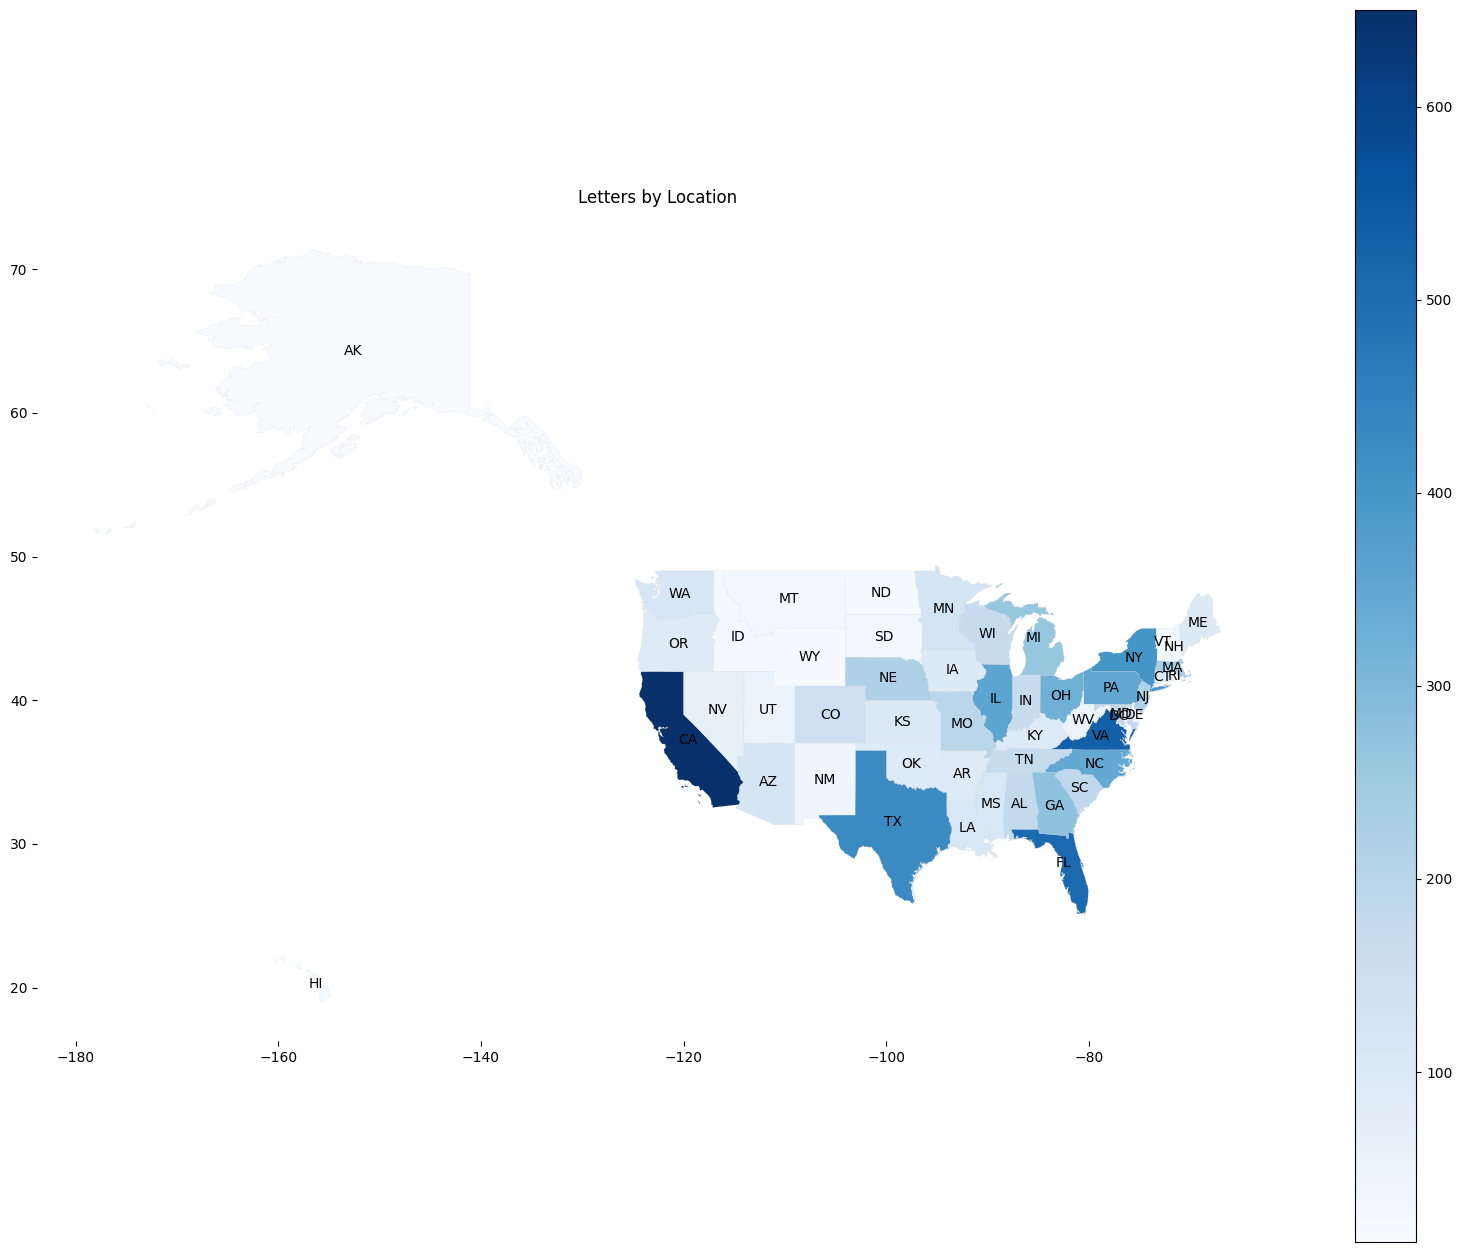

In [ ]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
merged_gdf.plot(column='doc_id', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8', legend=True)

# Set title
ax.set_title('Letters by Location')

# Annotate the state names using the 'State_Name' column
for index, row in merged_gdf.iterrows():
    state_name = row['State_Code']
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.text(x, y, state_name, fontsize=10, ha='center', va='center', color='black')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

# Percentage of categories

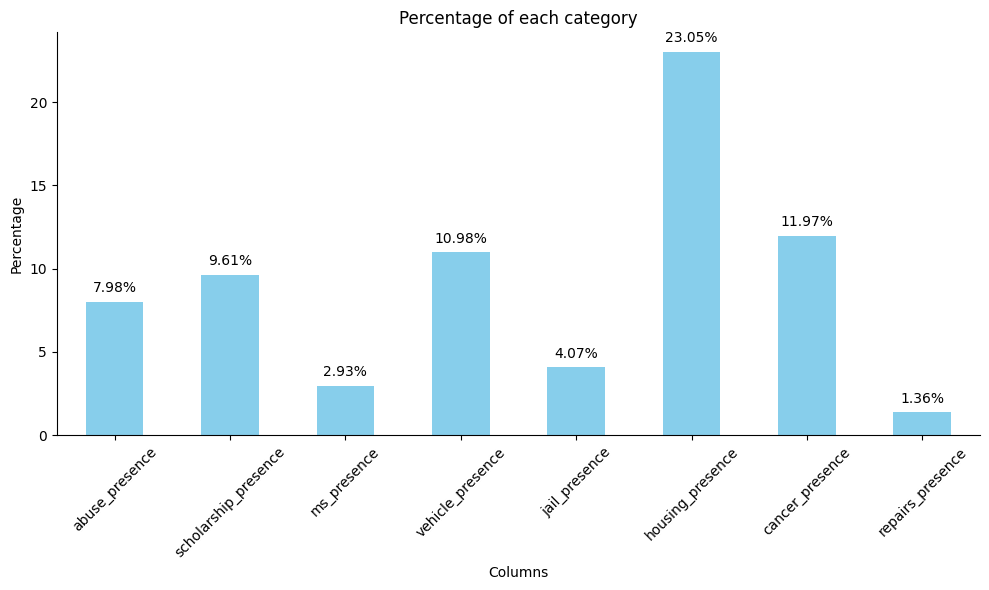

In [ ]:
column_means = df[['abuse_presence','scholarship_presence', 'ms_presence', 'vehicle_presence', 'jail_presence', 'housing_presence', 'cancer_presence','repairs_presence']].mean()*100
# Create a bar chart
plt.figure(figsize=(10, 6))
ax = column_means.plot(kind='bar', color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.title('Percentage of each category')
plt.xticks(rotation=45)
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

# Stat Test

In [ ]:
# Make sure the year are in the sensible range
df = df[(df['year'] >= 2006) & (df['year'] <= 2016)]

## Chi Square Test

In [ ]:
### Chi square
# Null hypothesis:
# Alternative:
abuse_sum = df.groupby('year').agg({'abuse_presence': 'sum', 'doc_id': 'count'})
abuse_sum['abuse_proportion'] = abuse_sum['abuse_presence'] / abuse_sum['doc_id']
abuse_sum

,abuse_presence,doc_id,abuse_proportion
year,,,
2006,7,216,0.032407
2007,46,455,0.101099
2008,111,1636,0.067848
2009,74,1731,0.042750
2010,180,1358,0.132548
2011,85,1137,0.074758
2012,62,772,0.080311
2013,34,401,0.084788
2014,25,256,0.097656


## ADF Test

In [38]:
df = df[(df['year'] >= 2006) & (df['year'] <= 2016)]

In [39]:
### ADF test
# Null hypothesis: the data series is not stationary
# Alternative: the data series is stationary
# We want to reject null hypothesis/ p-value < 0.05

# Group by 'date' and aggregate
df_grouped = df.groupby('date', as_index=False)['doc_id'].count()

# Loop through the list of columns
columns_to_test = ['abuse_presence', 'scholarship_presence', 'vehicle_presence',
                   'jail_presence', 'sn_presence', 'housing_presence',
                   'cancer_presence', 'ms_presence','repairs_presence']

results = []

for column in columns_to_test:
    df_new = df.groupby('date', as_index=False)[column].sum()

    # Merge the aggregated column into the grouped DataFrame
    df_grouped[column] = df_new[column]

    # Calculate the proportion
    df_grouped[f'{column}_proportion'] = df_grouped[column] / df_grouped['doc_id']

    # Extract the proportion column for ADF test
    proportion_series = df_grouped[f'{column}_proportion']

    # Perform ADF test
    result = adfuller(proportion_series,autolag='AIC')

    # Extract and store the ADF test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

   # Determine significance level based on p-value
    if p_value <= 0.01:
        significance = '***'
    elif p_value <= 0.05:
        significance = '**'
    elif p_value <= 0.1:
        significance = '*'
    else:
        significance = ''

    results.append({
        'Column': column,
        'ADF Statistic': adf_statistic,
        'P-value': f'{p_value:.4f}',
        'Significance': significance
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

results_df

,Column,ADF Statistic,P-value,Significance
0,abuse_presence,-2.823724,0.0550,*
1,scholarship_presence,-5.870138,0.0000,***
2,vehicle_presence,-2.678062,0.0779,*
3,jail_presence,-3.359166,0.0124,**
4,sn_presence,-11.428049,0.0000,***
5,housing_presence,-5.986342,0.0000,***
6,cancer_presence,-5.989472,0.0000,***
7,ms_presence,-11.231128,0.0000,***
8,repairs_presence,-3.931102,0.0018,***


# Before and after events

In [ ]:
df = df[(~df['month'].isna()) & (~df['year'].isna()) & (~df['day'].isna())]

df['date'] = pd.to_datetime(df[['year', 'month','day']], errors='coerce')
# df['date'] = df['date'].dt.to_period('M')

df

TV appearance

1. 6/26/2006:	Television	"ABC News:
Good Morning America"	GOOD MORNING AMERICA

2. 12/10/2007: W and D Buffett appear on the Early Show on CBS, discuss responding to letters

3. 6/7/2010: D Buffett promotes its authobography on Good morning America and Fox Business Chanel

4. 6/10/2010: PBS: The Charlie Rose Show	"Philanthropy and the Interesting Life of Doris Buffett"

In [84]:
medical = ["medical bill"]
df['medical_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=medical))
df['medical_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=medical))

credit_card = ['credit card debt']
df[f'credit_card_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=credit_card))
df['credit_card_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=credit_card))

mental_illness = ['mental illness','depression','bipolar']
df['mental_illness_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=mental_illness))
df['mental_illness_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=mental_illness))

recession = ['recession','bad economy','stock market crash']
df['recession_count'] = df['text'].apply(lambda x: count_phrases(x, phrases=recession))
df['recession_presence'] = df['text'].apply(lambda x: check_phrases(x, phrases=recession))

In [91]:
# Convert the target date to a Timestamp object
target_date = pd.Timestamp("2007-12-10")

In [92]:
### 7 DAYS BEFORE AND AFTER

# Calculate the date ranges
week_before_target = target_date - pd.DateOffset(days=8)
week_after_target = target_date + pd.DateOffset(days=7)

# Filter the DataFrame
filtered_df = df[(df['date'] >= week_before_target) & (df['date'] <= week_after_target)]

# Label week
filtered_df['week'] = 'after'  # Default week label
filtered_df.loc[(filtered_df['date'] >= week_before_target) & (filtered_df['date'] < target_date), 'week'] = 'before'

grouped_df = filtered_df.groupby('week').agg({'doc_id':'count', 'abuse_presence':'sum','scholarship_presence':'sum',\
                                 'ms_presence':'sum', 'vehicle_presence':'sum', 'jail_presence':'sum',\
                                'sn_presence':'sum','housing_presence':'sum', 'cancer_presence':'sum',\
                                 'repairs_presence':'sum', 'medical_presence':'sum',\
                                 'credit_card_presence':'sum','mental_illness_presence':'sum',\
                                 'recession_presence':'sum'})

columns = ['abuse_presence', 'scholarship_presence', 'vehicle_presence',
                   'jail_presence', 'sn_presence', 'housing_presence',
                   'cancer_presence', 'ms_presence','repairs_presence',
                   'medical_presence','credit_card_presence',
                   'mental_illness_presence','recession_presence']

for column in columns:
    grouped_df[f'{column}_proportion'] = grouped_df[column] / grouped_df['doc_id']

grouped_df

,doc_id,abuse_presence,scholarship_presence,ms_presence,vehicle_presence,jail_presence,sn_presence,housing_presence,cancer_presence,repairs_presence,...,jail_presence_proportion,sn_presence_proportion,housing_presence_proportion,cancer_presence_proportion,ms_presence_proportion,repairs_presence_proportion,medical_presence_proportion,credit_card_presence_proportion,mental_illness_presence_proportion,recession_presence_proportion
week,,,,,,,,,,,,,,,,,,,,,
after,129,21,11,4,26,9,0,26,22,0,...,0.069767,0.0,0.201550,0.170543,0.031008,0.0,0.093023,0.054264,0.108527,0.0
before,14,0,1,0,2,0,0,3,1,0,...,0.000000,0.0,0.214286,0.071429,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [96]:
### 4 WEEKS BEFORE AND AFTER

# Calculate the date ranges
week_before_target = target_date - pd.DateOffset(weeks=6)
week_after_target = target_date + pd.DateOffset(weeks=6)

# Filter the DataFrame
filtered_df = df[(df['date'] >= week_before_target) & (df['date'] <= week_after_target)]

# Label week
for i in range(0,14,2):
    filtered_df.loc[(filtered_df['date'] >= week_before_target+pd.DateOffset(weeks=i-2)) & (filtered_df['date'] < week_before_target+pd.DateOffset(weeks=i)), 'week'] = i

grouped_df = filtered_df.groupby('week').agg({'doc_id':'count', 'abuse_presence':'sum','scholarship_presence':'sum',\
                                 'ms_presence':'sum', 'vehicle_presence':'sum', 'jail_presence':'sum',\
                                'sn_presence':'sum','housing_presence':'sum', 'cancer_presence':'sum',\
                                 'repairs_presence':'sum', 'medical_presence':'sum',\
                                 'credit_card_presence':'sum','mental_illness_presence':'sum',\
                                 'recession_presence':'sum'})

for column in columns:
    grouped_df[f'{column}_proportion'] = grouped_df[column] / grouped_df['doc_id']

grouped_df

,doc_id,abuse_presence,scholarship_presence,ms_presence,vehicle_presence,jail_presence,sn_presence,housing_presence,cancer_presence,repairs_presence,...,jail_presence_proportion,sn_presence_proportion,housing_presence_proportion,cancer_presence_proportion,ms_presence_proportion,repairs_presence_proportion,medical_presence_proportion,credit_card_presence_proportion,mental_illness_presence_proportion,recession_presence_proportion
week,,,,,,,,,,,,,,,,,,,,,
2.0,10,1,1,0,0,0,0,3,3,0,...,0.000000,0.000000,0.300000,0.300000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000
4.0,8,1,1,0,0,0,0,1,1,0,...,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6.0,17,0,2,0,2,0,0,3,2,0,...,0.000000,0.000000,0.176471,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8.0,162,27,17,4,33,12,0,31,30,0,...,0.074074,0.000000,0.191358,0.185185,0.024691,0.000000,0.092593,0.055556,0.117284,0.000000
10.0,117,12,7,1,13,6,0,29,16,0,...,0.051282,0.000000,0.247863,0.136752,0.008547,0.000000,0.162393,0.025641,0.076923,0.000000
12.0,166,13,14,2,23,10,6,42,24,3,...,0.060241,0.036145,0.253012,0.144578,0.012048,0.018072,0.048193,0.024096,0.048193,0.006024


In [101]:
from scipy.stats import chisquare
import numpy as np
f_exp = np.array([2,33]) / 35 * 445
f_obs = np.array([52, 393])
chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=29.44841675178754, pvalue=5.742493243673184e-08)

In [100]:
f_exp = np.array([4, 31]) / 35 * 445
f_obs = np.array([17,7,14,145,110,152])
chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=30.130836454431957, pvalue=1.3899286996454019e-05)